### Load packages

In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import re
import sys

# Tomotopy
import tomotopy as tp

# Sklearn
from sklearn.datasets import fetch_20newsgroups

# Plotting
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge


# Gensim
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import LdaMallet


# Preprocessing

### Read 20newsgroup data from sklearn

In [10]:
# Read in train subset (11,314 observations)
news = fetch_20newsgroups(subset='train')

## Run custom preprocess function

This function does the following (and **has more user-defined parameters you can adjust**)

1. Reads-in sklearn 20newsgorup object

2. Builds a master df with content and labels

3. Removes content @ signs, new lines and single quotes

4. Tokenizes the document contents using `gensim` `simple_preprocess`

5. Creates bigrams from tokens using `gensim` `Phrases` and `Phraser`

6. Lemmatizes bigram nouns, verbs, adj and adv by default using `spaCy`



In [11]:
from scripts.newsgrp_preprocess import run_preprocess

news_df, word_list_lemmatized = run_preprocess(news)

Tokenizing...

Removing Stopwords...

Create bigrams...

Lemmatizing, keeping NOUN,VERB,ADV,ADJ POS tags...

Done preprocessing 11314 documents


In [5]:
word_list_lemmatized[0][:7]

['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line']

In [207]:
news_df.head()

,topic_id,content,topic_name
0,7,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,4,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,4,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,1,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,14,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space


### Stopwords removal example
Use nltk stopword list to keep non-stopwords

In [11]:
# Example of stop word removal process
sentence = "A letter has been written asking him to be released"
for word in sentence.split():
    if word not in st_words:
        print("Kept ==> " +word)
    else:
        print("Removed: " +word)

Kept ==> A
Kept ==> letter
Removed: has
Removed: been
Kept ==> written
Kept ==> asking
Removed: him
Removed: to
Removed: be
Kept ==> released


### Word Lemmatization Example

In [16]:
## Example showing lemmatization
sentence = "A letter has been written asking him to be released"

spC = spacy.load('en_core_web_sm')

lemma_sentence = spC(sentence)
for token in lemma_sentence:
    print(token.text + " ==> " +token.lemma_ + ", " + token.pos_)

A ==> a, DET
letter ==> letter, NOUN
has ==> have, AUX
been ==> be, AUX
written ==> write, VERB
asking ==> ask, VERB
him ==> -PRON-, PRON
to ==> to, PART
be ==> be, AUX
released ==> release, VERB


# HDP Model 
Using `tomotopy` package, explore differences between term weighting schemes and potential to overfit. Then choose best model based on `gensim` $C_V$ coherence value and lower potential to overfit based on predicted topics on 20newsgroup test set.

Ideally, given this data set and goals, our ideal scenario is to choose a model with high topic coherence and also able to correctly assign topics related to the known categories out-of-sample


### Train Models

Weighting schemes available in `tomotopy` are based on

_Wilson, A. T., & Chew, P. A. (2010, June). Term weighting schemes for latent dirichlet allocation. In human language technologies: The 2010 annual conference of the North American Chapter of the Association for Computational Linguistics (pp. 465-473). Association for Computational Linguistics._

<img src="imgs/HDP.png" style="width:50%; height:60%;">

In [198]:
from scripts.model_funcs import train_HDPmodel, get_hdp_topics


tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['models/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))
    

Model one


Training...


Num docs: 11314 , Vocab size: 12716 , Num words: 1004667
Removed top words: ['line', 'would', 'write', 'say', 'know', 'article', 'people']
Iteration: 0	Log-likelihood: -7.712365254737525	Num. of topics: 18
Iteration: 100	Log-likelihood: -7.706041513770898	Num. of topics: 18
Iteration: 200	Log-likelihood: -7.7051653242534615	Num. of topics: 21
Iteration: 300	Log-likelihood: -7.704958476969545	Num. of topics: 20
Iteration: 400	Log-likelihood: -7.704374225081427	Num. of topics: 20
Iteration: 500	Log-likelihood: -7.704238850831999	Num. of topics: 19
Iteration: 600	Log-likelihood: -7.703806321057353	Num. of topics: 19
Iteration: 700	Log-likelihood: -7.703864934853037	Num. of topics: 19
Iteration: 800	Log-likelihood: -7.703910731345387	Num. of topics: 20
Iteration: 900	Log-likelihood: -7.703786860680925	Num. of topics: 19
Done

Model pmi


Training...


Num docs: 11314 , Vocab size: 12716 , Num words: 1004667
Removed top words: ['line', 'would', 'write', 'say', 'know', 'article', 'people']
Iteration: 0	Log-likelihood: -26.58106992419327	Num. of topics: 19
Iteration: 100	Log-likelihood: -26.57527414332486	Num. of topics: 19
Iteration: 200	Log-likelihood: -26.56701274281081	Num. of topics: 19
Iteration: 300	Log-likelihood: -26.5641627575212	Num. of topics: 21
Iteration: 400	Log-likelihood: -26.563993308689124	Num. of topics: 21
Iteration: 500	Log-likelihood: -26.56340556119194	Num. of topics: 21
Iteration: 600	Log-likelihood: -26.56503023547606	Num. of topics: 21
Iteration: 700	Log-likelihood: -26.565158325304807	Num. of topics: 21
Iteration: 800	Log-likelihood: -26.565222693070893	Num. of topics: 22
Iteration: 900	Log-likelihood: -26.56639793188253	Num. of topics: 22
Done

Model idf


Training...


Num docs: 11314 , Vocab size: 12716 , Num words: 1004667
Removed top words: ['line', 'would', 'write', 'say', 'know', 'article', 'people']
Iteration: 0	Log-likelihood: -30.31335799134768	Num. of topics: 24
Iteration: 100	Log-likelihood: -30.309085266776293	Num. of topics: 23
Iteration: 200	Log-likelihood: -30.308479105471218	Num. of topics: 24
Iteration: 300	Log-likelihood: -30.30659000329051	Num. of topics: 25
Iteration: 400	Log-likelihood: -30.30773866980525	Num. of topics: 24
Iteration: 500	Log-likelihood: -30.30679266818671	Num. of topics: 25
Iteration: 600	Log-likelihood: -30.307926657428634	Num. of topics: 24
Iteration: 700	Log-likelihood: -30.307048882399776	Num. of topics: 25
Iteration: 800	Log-likelihood: -30.30787239657232	Num. of topics: 24
Iteration: 900	Log-likelihood: -30.30818635357596	Num. of topics: 24
Done



### Term weighting comparision / evaluation

First we evaluate these models based on topic coherence which as it name says aims to evaluate whether a topic makes sense. There are multiple ways to compute this metric (UMass, UCI, CV, etc). All share the same basic notion that coherence is computed based on the co-ocurrences of words in a topic across all documents (e.g. if all the words in a topic appear together a lot, then it makes sense these words should be together semantically).

However, it seems the $C_V$ way to compute it produces results that most resemble human intuition thus I used that metric here.

In [3]:
from scripts.model_funcs import get_hdp_topics
hdp_one = tp.HDPModel.load("models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("models/hdp_model_idf.bin")

model_topics =[get_hdp_topics(hdp_one), 
               get_hdp_topics(hdp_pmi), 
               get_hdp_topics(hdp_idf)]


In [205]:
from scripts.model_funcs import eval_coherence

coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)



Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



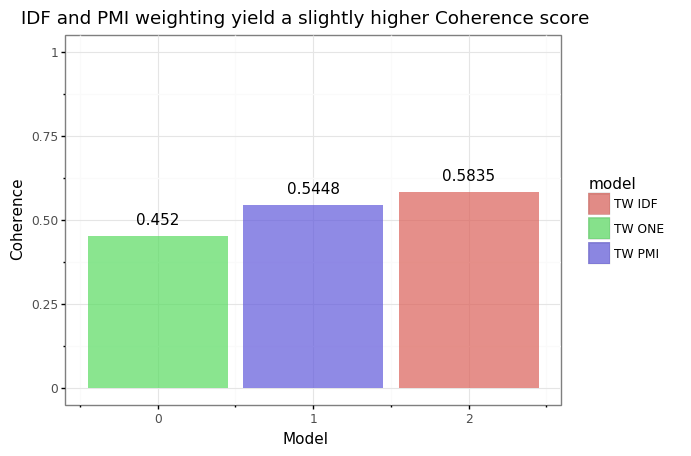

<ggplot: (443438313)>

In [206]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)


### Out-of-sample prediction comparisons

When evaluating a model it is important to not do some additional sanity checks aside from our sufficient statistic. For example, can the model generalize well. In other words, if we give it an uknown document can it infer the topic correctly.

There are times we can't really assess this direclty, however given the 20Newsgroup dataset has labels we are able to do so with our models.

In [5]:
##### Prepare test data set
news_test = fetch_20newsgroups(subset='test')

test_df, lemmatized_test =  run_preprocess(news_test)

Tokenizing...

Removing Stopwords...

Create bigrams...

Lemmatizing, keeping NOUN,VERB,ADV,ADJ POS tags...

Done preprocessing 7532 documents


In [108]:
test_df.head(8)

,topic_id,content,topic_name
0,7,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,rec.autos
1,5,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,comp.windows.x
2,0,From: mathew <mathew@mantis.co.uk>\nSubject: R...,alt.atheism
3,17,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,talk.politics.mideast
4,19,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,talk.religion.misc
5,13,From: banschbach@vms.ocom.okstate.edu\nSubject...,sci.med
6,15,From: PETCH@gvg47.gvg.tek.com (Chuck)\nSubject...,soc.religion.christian
7,15,From: fortmann@superbowl.und.ac.za (Paul Fortm...,soc.religion.christian


#### Example predictions
1) One where all models agree

2) One where they don't agree (cautionary tale about blindly thinking coherence is the end all)

In [213]:
from scripts.wordcloud_funcs import create_wordcloud

hdp_one = tp.HDPModel.load("models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("models/hdp_model_idf.bin")

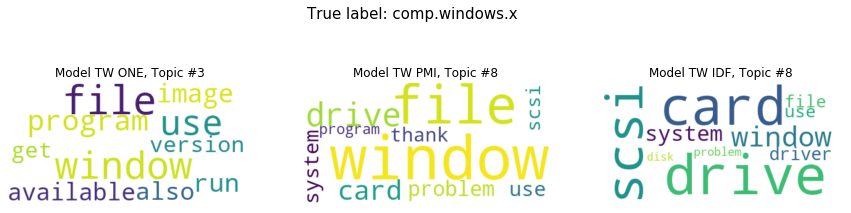

In [279]:
### All models topics agree with true label

# Infering topics from out of sample text
test_idx = 1

models = [hdp_one, hdp_pmi, hdp_idf]
model_names = df_coherence.model.values
doc_preds = []
test_doc = lemmatized_test[test_idx] # out-of-sample lemmatized test, ex. get 3rd entry in table above


fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle("True label: " + test_df.topic_name.values[test_idx], size=15)

# Infer MOST LIKELY topic
for i, m in enumerate(models):
    doc_inst = m.make_doc(test_doc)
    topic_dist, ll = m.infer(doc_inst, together=True)
    topic_idx = np.array(topic_dist).argmax()
    
    doc_preds.append((topic_idx, ll))
    
    create_wordcloud(models[i], topic_idx, fig, ax[i])
  
    ax[i].title.set_text("Model " + str(model_names[i]) + ", Topic #" + str(topic_idx))


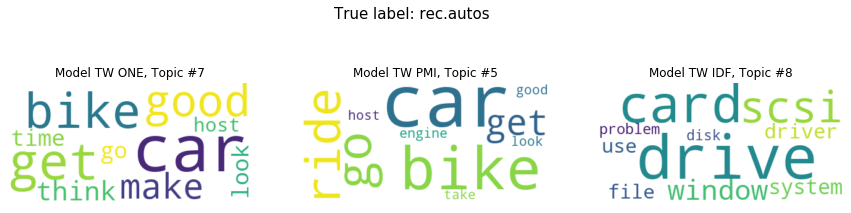

In [280]:
### Not all models topics agree with true label, even the one with most coherence can get it wrong

test_idx = 0

models = [hdp_one, hdp_pmi, hdp_idf]
model_names = df_coherence.model.values
doc_preds = []
test_doc = lemmatized_test[test_idx] # out-of-sample lemmatized test, ex. get 3rd entry in table above

fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle("True label: " + test_df.topic_name.values[test_idx], size=15)

# Infer MOST LIKELY topic
for i, m in enumerate(models):
    doc_inst = m.make_doc(test_doc)
    topic_dist, ll = m.infer(doc_inst, together=True)
    topic_idx = np.array(topic_dist).argmax()
    
    doc_preds.append((topic_idx, ll))
    
    create_wordcloud(models[i], topic_idx, fig, ax[i])
  
    ax[i].title.set_text("Model " + str(model_names[i]) + ", Topic #" + str(topic_idx))


## Best model
Based on a trade-off between coherence and true label inference the model with a  **IDF** term-weighting scheme seems to produce best results given our goals is to see if we can obtain the original topics.

In [400]:
hdp_best = hdp_idf

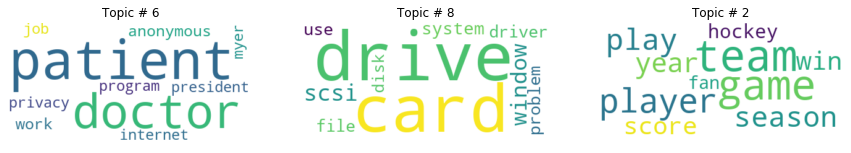

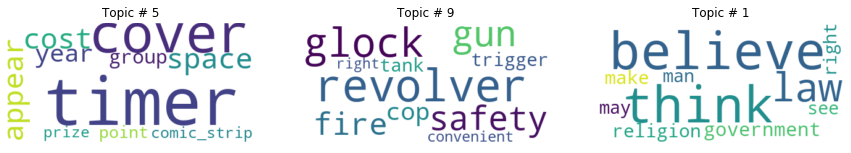

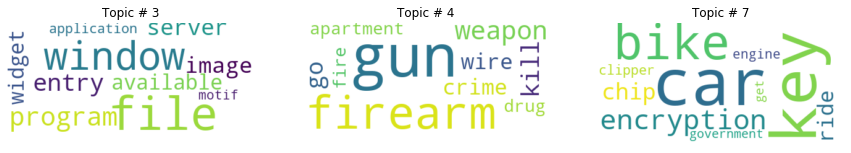

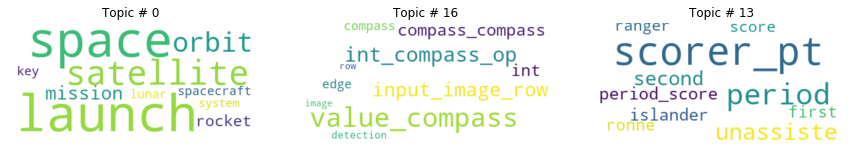

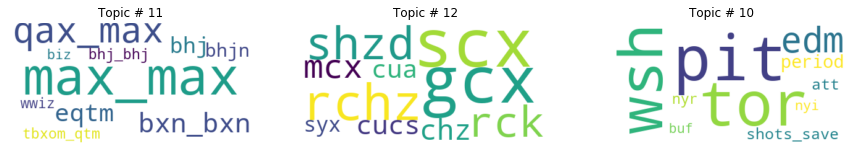

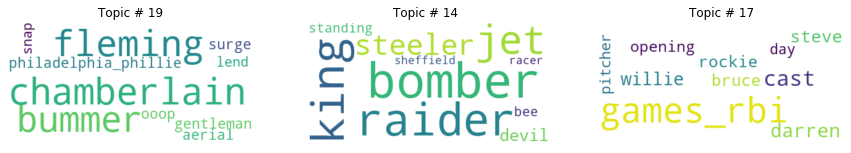

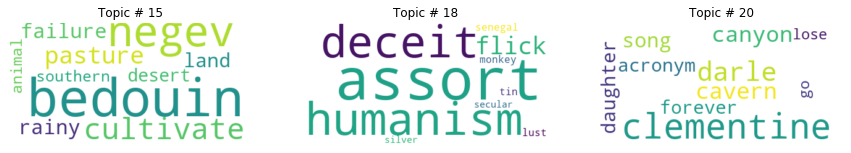

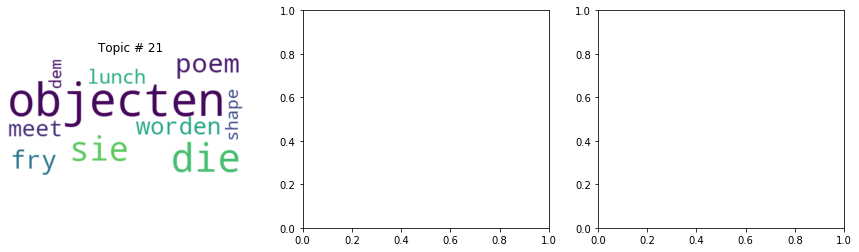

In [401]:
from scripts.wordcloud_funcs import hdp_topics_to_wordclouds

pmi_topics = model_topics[1]
hdp_topics_to_wordclouds(hdp_best, pmi_topics, save=True)

## Appending topics info to original news_df

It is sometimes helpful to keep all information together, thus we add some information from the model to the `news_df` such as the topic number inferred and the associated top 10 keywords.

In [402]:

def topic_importance(model, news_df, txt):
    ''''''
    out_df = pd.DataFrame()
    
    for i, row in enumerate(txt):
        doc_inst = model.make_doc(row)
        topic_dist, ll = model.infer(doc_inst, together=True)
        topic_idx = np.array(topic_dist).argmax()
  
        words = dict(model.get_topic_words(topic_idx)).keys()
        k_words = ", ".join(list(words))
        out_df = out_df.append(pd.Series([int(topic_idx), k_words]), ignore_index=True)
    
    original_docs = pd.Series(news_df.content.values)
    true_labels = pd.Series(news_df.topic_name.values)
    out_df = pd.concat([out_df, true_labels, original_docs], axis=1)
    
    
    return out_df

In [411]:
#top_k = topic_importance(hdp_best, news_df, word_list_lemmatized)

#top_dominant = top_k.reset_index()
#top_dominant.columns = ['Document_No', 'Dominant_Topic', 'Topic_Keywords', "True_Topic", 'Text']

top_dominant = pd.read_csv("top_dominant.csv") # given the top_k above can take some time to run

with option_context('display.max_colwidth', 100):
    display(top_dominant.head(8))

,Document_No,Dominant_Topic,Topic_Keywords,True_Topic,Text
0,0,7.0,"car, key, bike, encryption, chip, ride, clipper, engine, government, get",rec.autos,From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac...
1,1,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.mac.hardware,From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Fi...
2,2,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.mac.hardware,From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdu...
3,3,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.graphics,From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Syste...
4,4,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",sci.space,From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrgani...
5,5,4.0,"gun, firearm, weapon, kill, go, crime, wire, apartment, fire, drug",talk.politics.guns,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\nSubject: Re: Rewording the Second Amendment (idea...
6,6,6.0,"patient, doctor, anonymous, work, president, privacy, internet, job, program, myer",sci.med,From: bmdelane@quads.uchicago.edu (brian manning delaney)\nSubject: Brain Tumor Treatment (thank...
7,7,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.ibm.pc.hardware,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: Re: IDE vs SCSI\nOrganization: New Mexico State Un...


Similarly, we might want to explore how many times 

In [413]:
# Number of Documents for Each Topic
topic_cnts = top_dominant['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_cnts/topic_cnts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = top_dominant[['Dominant_Topic', 'Topic_Keywords', 'True_Topic']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_cnts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords','True_Topic', 'Num_Documents', 'Perc_Documents']


with option_context('display.max_colwidth', 200):
    display(df_dominant_topics.sort_values(by="Perc_Documents", ascending=False).head(10))

,Dominant_Topic,Topic_Keywords,True_Topic,Num_Documents,Perc_Documents
8.0,3.0,"file, window, program, entry, server, image, available, widget, application, motif",comp.os.ms-windows.misc,2998.0,0.2650
1.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.mac.hardware,2631.0,0.2325
7.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.ibm.pc.hardware,1737.0,0.1535
2.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.mac.hardware,1136.0,0.1004
3.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.graphics,945.0,0.0835
4.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",sci.space,648.0,0.0573
6.0,6.0,"patient, doctor, anonymous, work, president, privacy, internet, job, program, myer",sci.med,571.0,0.0505
0.0,7.0,"car, key, bike, encryption, chip, ride, clipper, engine, government, get",rec.autos,338.0,0.0299
5.0,4.0,"gun, firearm, weapon, kill, go, crime, wire, apartment, fire, drug",talk.politics.guns,195.0,0.0172
9.0,8.0,"drive, card, scsi, window, system, driver, file, use, problem, disk",comp.sys.mac.hardware,64.0,0.0057


# Model Comparison


### Fit MALLET LDA 

In [ ]:
#! curl -O http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#! unzip mallet-2.0.8.zip
#! rm mallet-2.0.8.zip

In [414]:
mallet_path = "mallet-2.0.8/bin/mallet"

In [415]:
def lda_coherence_vals(corpus, vocab, txt, stop, start=2, step_size=6):
    '''Computes LDA coherences values for a given range of topics'''
    
    c_scores = []

    for n_topic in range(start, stop, step_size):
        lda = LdaMallet(mallet_path, corpus=corpus, id2word=vocab, num_topics=n_topic)
        coherence_lda = CoherenceModel(model=lda, dictionary=vocab, texts=txt, coherence='c_v')
        c_scores.append(coherence_lda.get_coherence())
        
    return c_scores
    

In [416]:
vocab = corpora.Dictionary(word_list_lemmatized)
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

steps = 6
stop = 40
coherence_vals = lda_coherence_vals(corpus, vocab, word_list_lemmatized, 
                                    stop=40, start=2, step_size=steps )


### Comparison to HDP models

HDP models can attain similar coherence score to that of LDA without having to pre-specify the number of topics. Similarly, given this particular dataset seems to imply there are 20 topics we can compare the inference of an LDA model with 20 topics and the best HDP model (HDP_IDF in our case)

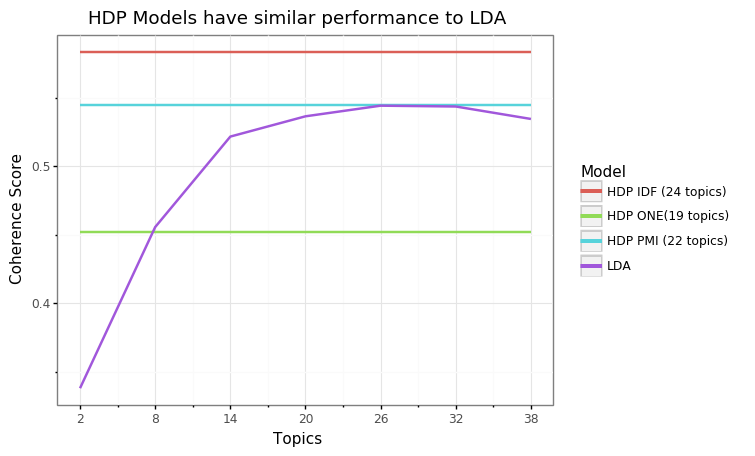

<ggplot: (325486113)>

In [468]:

topics = list(range(2,stop,steps))
idf_coherence = df_coherence.value

df = pd.DataFrame([topics, coherence_vals]).T

for v in idf_coherence:
    vals = pd.Series(np.repeat(v, len(topics)))
    df = pd.concat([df, vals], axis=1)

df.columns = ["topics", "LDA", "HDP ONE(19 topics)", "HDP PMI (22 topics)", "HDP IDF (24 topics)"]
df_melt = df.melt(id_vars=["topics"], var_name="Model")

(ggplot(df_melt, aes(x='topics', y='value', color='Model')) +
 geom_line(size=1) +
 labs(x = 'Topics', y="Coherence Score", title="HDP Models have similar performance to LDA")+
 theme_bw() +
 scale_x_continuous(breaks = topics)
)


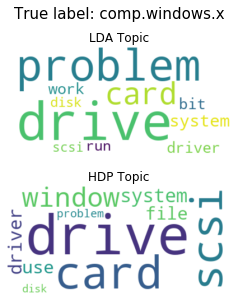

In [504]:
from wordcloud import WordCloud

test_idx = 1

test_doc = lemmatized_test[test_idx] # out-of-sample lemmatized test, ex. get 3rd entry in table above

fig, ax = plt.subplots(2, 1, figsize=(15,4), )
fig.suptitle("True label: " + test_df.topic_name.values[test_idx], size=15, y=1.05)
wcloud = WordCloud(background_color='white')

### LDA MALLET
t , freq = sorted(best_lda[corpus[test_idx]], key=lambda x:x[1], reverse=True)[0]
topic_freqs = dict(best_lda.show_topic(t))
img = wcloud.generate_from_frequencies(topic_freqs)
ax[0].imshow(img, interpolation='bilinear')
ax[0].axis('off')
ax[0].title.set_text("LDA Topic")

### HDP IDF
doc_inst = hdp_best.make_doc(test_doc)
topic_dist, ll = hdp_best.infer(doc_inst, together=True)
t_idx = np.array(topic_dist).argmax()
create_wordcloud(hdp_best, t_idx, fig, ax[1])
ax[1].title.set_text("HDP Topic")

fig.tight_layout()


# Cautionary Tales
Here are some examples of why you **shouldn't trust coherence or a statistic blindly** and should instead 

1. Understand the method generating the topic inferences so you know when and why things might break
2. Double check your results

In [577]:
from gensim.models import HdpModel

# Filter outlier words (e.g. appear <10 docs or in over 50% of docs)
vocab = corpora.Dictionary(word_list_lemmatized)
vocab.filter_extremes(no_below=20, no_above=0.5)
vocab.compactify()

# Build corpus
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Just changing the learning rate and truncation level
hdp = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=1, random_state=20) # default kappa
hdp08 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.8, random_state=20)
hdp06 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.6, random_state=20)


In [578]:
vb_model = [hdp06, hdp08, hdp]
vb_coherence =[]

for m in vb_model:
    cm = CoherenceModel(m, texts=word_list_lemmatized, corpus=corpus, dictionary=vocab, coherence='c_v')
    vb_coherence.append(cm.get_coherence())

In [575]:
pd.DataFrame(vb_coherence, index=['hdp_kap06', 'hdp_kap08', 'hdp_kap1']).T


,hdp_kap06,hdp_kap08,hdp_kap1
0,0.355007,0.50629,0.602409


In [576]:
import pyLDAvis.gensim
py_corpus = [x for x in corpus if len(x) > 0]
prep= pyLDAvis.gensim.prepare(hdp, py_corpus, vocab)
pyLDAvis.display(prep)


# Dash App 
Hosted in heroku at https://vb-learning-rate-demo.herokuapp.com/

Trying out new `jupyter-dash` feature to render in inline below

```
pip3 install jupyter-dash
```

### Main code

In [9]:

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import numpy as np

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# Create layout
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)


# Add layout buttons and info
app.layout = html.Div([
    html.Div([
            dcc.Markdown('''
            ### Online Variational Bayes Learning Rate Demo
            
            The following demo showcases how the parameters **tau** and **kappa** affect the learning
            rate of the online VB method. This learning rate is similar to that used in gradient optimization
            methods such as Newton-Raphson. 
            
            To guarantee convergence *kappa* has to be between 0.5-1 and **tau**>0 
            
            [See original paper](https://www.di.ens.fr/~fbach/mdhnips2010.pdf)
            '''),],
            style={'padding-left': '30px','width': '80%', 'display': 'inline-block'}),
    
    html.Div([

        html.Div([
            dcc.Markdown("###### `tau`", style={'padding-left':'20px'}),
            dcc.Slider(
                id='tau-input',
                min=1,
                max=10,
                value=1,
                marks={str(i): str(i) for i in np.arange(1, 10, 1)},
                step=1)],
            style={'flex': '50%','padding': '10px 10px 10px 30px'}),

        html.Div([
            dcc.Markdown("###### `kappa`", style={'padding-left':'20px'}),
            dcc.Slider(
                id='kappa-slider',
                min=0.5,
                max=1,
                value=1,
                marks={str(round(i,3)): str(round(i,3)) for i in np.arange(0.5, 1.01, 0.05)},
                step=0.05),
            
            html.Div(id='slider-output-container', style={'padding-left':'20%'})
        ],
            style={'flex': '50%','padding': '10px'})
        
    ], style={'display': 'flex', 'width':'80%'}),

    dcc.Graph(id='learning-rate', style={'width':'80%'}),

])

# Create callback functions

# Text output under slider
@app.callback(
    Output('slider-output-container', 'children'),
    [Input('tau-input', 'value'),
     Input('kappa-slider', 'value')])
def update_output(tau, kappa):
    return 'Start learning rate: {:2f}'.format((1+tau)**(-kappa))

# Graph
@app.callback(
    Output('learning-rate', 'figure'),
    [Input('tau-input', 'value'),
     Input('kappa-slider', 'value')])
def update_graph(tau, kappa):
    
    lr = lambda t: (t + tau)**(-kappa)
    
    t = np.arange(0.0,60.0, 1.0)
    
    return {
        'data': [dict(
            x=t,
            y=lr(t))
                ],
        'layout': dict(
            xaxis={
                'title': 'Iterations (t)',
                'type': 'linear'
            },
            yaxis={
                'title': 'Learning rate',
                'type': 'linear',
                'range': [0, 1]
            },
            title={
                'text':'Learning rate decay over 60 iterations'},
        )
    }


### Running the app

Modes include `inline`, `external` and `jupyterlab`

In [11]:
app.run_server(mode='inline')